#####    
학번: 2021136138   
이름: 추승연

# [문제 1]    
수업 자료에서 제시하고 있는 다음 코드들을 Colab으로 옮겨 실행하고 각 결과를 Colab내에 잘 정리하여 제시하기

In [17]:
import os
print(os.getcwd())  # 현재 작업 디렉터리 출력


/home/work/dl_choo


In [18]:
BASE_PATH = os.getcwd()  # 현재 디렉터리를 BASE_PATH로 설정


In [19]:
btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")


In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 38.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 268.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 137.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 235.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 241.6 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=843016 sha256=d69194559fbd93bdaa7bbc67021ac016a702350ccab63061d7a4eeb0355deeb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-b189ge9d/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built 

## 기본 코드

##### wandb

In [20]:
# 설치
!pip install --upgrade wandb -qq

In [21]:
# 로그인

import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

##### import

In [22]:
from datetime import datetime
import os
from pathlib import Path
import sys
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import wandb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Set BASE_PATH (현재 작업 디렉터리 설정)
BASE_PATH = "/home/work/dl_choo"  # 현재 디렉터리로 설정
print(f"BASE_PATH 설정: {BASE_PATH}")
sys.path.append(BASE_PATH)

# Set CHECKPOINT_FILE_PATH (체크포인트 디렉터리 설정)
CURRENT_FILE_PATH = os.getcwd()  # 현재 작업 디렉터리를 사용
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)
print(f"CHECKPOINT_FILE_PATH 설정: {CHECKPOINT_FILE_PATH}")


BASE_PATH 설정: /home/work/dl_choo
CHECKPOINT_FILE_PATH 설정: /home/work/dl_choo/checkpoints


##### utils

In [23]:
# _01_code/_99_common_utils/utils.py

import os
import sys


def is_linux():
    if sys.platform.startswith("linux"):
        return True
    else:
        return False


def is_windows():
    if os.name == "nt":
        return True
    else:
        return False


def is_mac():
    if sys.platform == "darwin":
        return True
    else:
        return False


def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()


from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)


def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )


if __name__ == "__main__":
    if is_linux():
        print("Linux")
    elif is_windows():
        print("Windows")
    elif is_mac():
        print("Mac")
    else:
        print("<unknown>")


Linux


##### get_parser

In [24]:
import argparse


def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
  )

  parser.add_argument(
    "-w", "--weight_decay", type=float, default=0.0, help="Weight decay (float, default: 0.0)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=30,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=30,
    help="Number of early stop patience (int, default: 10)"
  )

  parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.000001,
    help="Delta value of early stop (float, default: 0.000001)"
  )

  return parser


##### class EarlyStopping

In [25]:
import os
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
        self.patience = patience
        self.counter = 0
        self.delta = delta
        self.val_loss_min = float('inf')  # 초기값을 무한대로 설정

        # 경로 설정 및 생성
        self.file_path = os.path.join(checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt")
        self.latest_file_path = os.path.join(checkpoint_file_path, f"{project_name}_checkpoint_latest.pt")
        os.makedirs(checkpoint_file_path, exist_ok=True)

    def check_and_save(self, new_validation_loss, model):
        early_stop = False

        if new_validation_loss < self.val_loss_min - self.delta:
            message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
            self.save_checkpoint(new_validation_loss, model)
            self.val_loss_min = new_validation_loss
            self.counter = 0
        else:
            self.counter += 1
            message = f'Early stopping counter: {self.counter} out of {self.patience}'
            if self.counter >= self.patience:
                early_stop = True
                message += " *** TRAIN EARLY STOPPED! ***"

        return message, early_stop

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        torch.save(model.state_dict(), self.file_path)
        torch.save(model.state_dict(), self.latest_file_path)
        self.val_loss_min = val_loss


##### class CryptoCurrencyDataset

In [26]:
class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str




## 실습 코드

### _01_code/_11_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py

##### get_crytocurrency_data

In [27]:
def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    BASE_PATH = "/home/work/dl_choo/"  # 실제 파일 경로 설정
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")  # 파일 경로 설정
    df = pd.read_csv(btc_krw_path)  # 데이터 읽기
    row_size = len(df)
    # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    date_list = df['Date']

    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)
    #################################################################################################

    row_cursor = 0

    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, unbiased=False, keepdim=True)
    X_train = (X_train - m) / s

    #################################################################################################

    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s
    #################################################################################################

    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


##### get_btc_krw_data

In [57]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7):
    # CSV 파일 읽기 (첫 번째 줄을 열 이름으로 설정)
    df = pd.read_csv('BTC_KRW.csv', header=0)
    
    # 열 이름 설정
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    
    # 데이터 타입 변환
    df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d')  # 날짜 열 변환
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')  # 숫자 열 변환
    
    # NaN 값 처리
    if df.isnull().any().any():
        print("NaN 값이 발견되었습니다. 이를 0으로 채웁니다.")
        df = df.fillna(0)

    # 날짜 열 제거 (학습에는 필요 없으므로)
    df = df.drop(columns=['Date'])

    # 데이터셋 분리
    data_size = len(df) - sequence_size
    train_size = data_size - (validation_size + test_size)

    # 학습 데이터 준비
    X_train, y_train = [], []
    for i in range(train_size):
        X_train.append(torch.tensor(df.iloc[i:i + sequence_size].values, dtype=torch.float32))
        y_train.append(torch.tensor(df.iloc[i + sequence_size][target_column], dtype=torch.float32) / y_normalizer)

    # 검증 데이터 준비
    X_validation, y_validation = [], []
    for i in range(train_size, train_size + validation_size):
        X_validation.append(torch.tensor(df.iloc[i:i + sequence_size].values, dtype=torch.float32))
        y_validation.append(torch.tensor(df.iloc[i + sequence_size][target_column], dtype=torch.float32) / y_normalizer)

    # 테스트 데이터 준비
    X_test, y_test = [], []
    for i in range(train_size + validation_size, len(df) - sequence_size):
        X_test.append(torch.tensor(df.iloc[i:i + sequence_size].values, dtype=torch.float32))
        y_test.append(torch.tensor(df.iloc[i + sequence_size][target_column], dtype=torch.float32) / y_normalizer)

    # DataLoader 반환
    train_dataset = TensorDataset(torch.stack(X_train), torch.stack(y_train))
    validation_dataset = TensorDataset(torch.stack(X_validation), torch.stack(y_validation))
    test_dataset = TensorDataset(torch.stack(X_test), torch.stack(y_test))

    train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=2048, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

    return train_loader, validation_loader, test_loader


##### class RegressionTrainer

In [52]:
class RegressionTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.MSELoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)

      loss_train += loss.item()

      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains

    return train_loss

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)

        loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()

        num_validations += 1

    validation_loss = loss_validation / num_validations

    return validation_loss

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 1000 * epoch / elapsed_time.microseconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"V_loss: {validation_loss:7.5f}, "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Validation loss": validation_loss,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


##### get_model

In [53]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model

##### main

In [54]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

##### run

In [58]:
if __name__ == "__main__":
  args_str = "--wandb"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 11.18919, V_loss: 83.23045, V_loss decreased (    inf --> 83.23045). Saving model... | T_time: 00:00:00, T_speed: 0.005
[Epoch  30] T_loss: 6.61101, V_loss: 57.89265, V_loss decreased (83.23045 --> 57.89265). Saving model... | T_time: 00:00:01, T_speed: 0.037
[Epoch  60] T_loss: 6.07941, V_loss: 48.13003, V_loss decreased (57.89265 --> 48.13003). Saving model... | T_time: 00:00:03, T_speed: 0.144
[Epoch  90] T_loss: 6.03800, V_loss: 47.86065, V_loss decreased (48.13003 --> 47.86065). Saving model... | T_time: 00:00:05, T_speed: 8.826
[Epoch 120] T_loss: 6.04157, V_loss: 47.90630, Early stopping counter: 1 out of 3

[Epoch 1950] T_loss: 6.02732, V_loss: 47.93109, Early stopping counter: 22 out of 30 | T_time: 00:01:36, T_speed: 2.072
[Epoch 1980] T_loss: 6.03597, V_loss: 47.77248, Early stopping counter: 23 out of 30 | T_time: 00:01:38, T_speed: 4.953
[Epoch 2010] T_loss: 6.02389, V_loss: 48.06266, Early stopping counter: 24 out of 30 | T_time: 00:01:39, T_speed: 2.122
[Epoch 2040] T_loss: 6.01066, V_loss: 47.86543, Early stopping counter: 25 out of 30 | T_time: 00:01:41, T_speed: 4.312
[Epoch 2070] T_loss: 6.06120, V_loss: 47.92863, Early stopping counter: 26 out of 30 | T_time: 00:01:42, T_speed: 2.367
[Epoch 2100] T_loss: 6.00512, V_loss: 47.87243, Early stopping counter: 27 out of 30 | T_time: 00:01:44, T_speed: 10.830
[Epoch 2130] T_loss: 6.04643, V_loss: 48.04612, Early stopping counter: 28 out of 30 | T_time: 00:01:45, T_speed: 2.957
[Epoch 2160] T_loss: 6.02542, V_loss: 47.85180, Early stopping counter: 29 out of 30 | T_time: 00:01:47, T_speed: 39.737
[Epoch 2190] T_loss: 6.02133, V_loss: 

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▃▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▄▁▃▁▁▁▃▁▁▁▁▂▁▂▁▂▁▂█
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2190
Training loss,6.02133
Training speed (epochs/sec.),4.12613
Validation loss,47.8544


###### run2

In [59]:
if __name__ == "__main__":
  args_str = "--wandb"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 11.70984, V_loss: 85.34174, V_loss decreased (    inf --> 85.34174). Saving model... | T_time: 00:00:00, T_speed: 0.021
[Epoch  30] T_loss: 7.28409, V_loss: 63.38629, V_loss decreased (85.34174 --> 63.38629). Saving model... | T_time: 00:00:01, T_speed: 0.053
[Epoch  60] T_loss: 6.07665, V_loss: 48.12790, V_loss decreased (63.38629 --> 48.12790). Saving model... | T_time: 00:00:03, T_speed: 0.392
[Epoch  90] T_loss: 6.00886, V_loss: 47.90974, V_loss decreased (48.12790 --> 47.90974). Saving model... | T_time: 00:00:04, T_speed: 0.125
[Epoch 120] T_loss: 6.07436, V_loss: 47.88315, V_loss decreased (47.90974 --> 47.

Epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
Training loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁█▁▁
Validation loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1860
Training loss,6.06243
Training speed (epochs/sec.),2.77367
Validation loss,47.88783


### _01_code/_11_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py

##### test

In [60]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

##### predict_all

In [61]:
def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

##### main

In [62]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


##### run

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 403.66 <--> 405.02 (Loss:          1.36)
 1: 402.35 <--> 404.00 (Loss:          1.65)
 2: 456.57 <--> 462.33 (Loss:          5.76)
 3: 461.27 <--> 468.41 (Loss:          7.14)
 4: 462.91 <--> 459.89 (Loss:          3.02)
 5: 450.55 <--> 455.68 (Loss:          5.14)
 6: 464.27 <--> 464.58 (Loss:          0.31)
 7: 472.23 <--> 461.57 (Loss:         10.66)
 8: 460.84 <--> 466.85 (Loss:          6.01)
 9: 403.87 <--> 444.08 (Loss:         40.21)


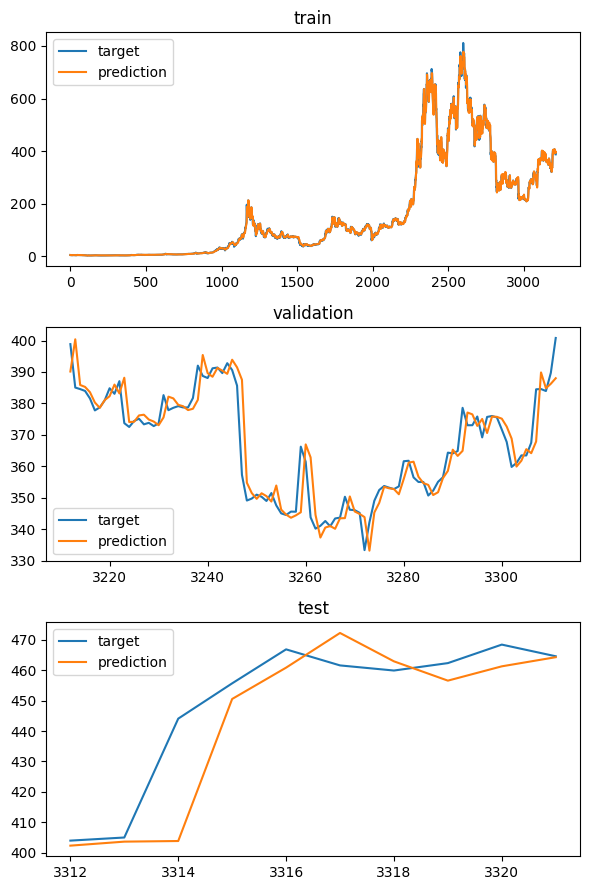

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


### _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py

##### get_crytocurrency_data

In [63]:
def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=False
):
    BASE_PATH = "/home/work/dl_choo"  # 경로를 명시적으로 설정
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
    
    # 데이터 읽기
    if not os.path.exists(btc_krw_path):
        raise FileNotFoundError(f"File not found: {btc_krw_path}")
    df = pd.read_csv(btc_krw_path)

    if len(df) < sequence_size + validation_size + test_size:
        raise ValueError("Dataset is too small for the given parameters.")

    # 'Date' 컬럼 삭제
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    # 데이터셋 크기 계산
    data_size = len(df) - sequence_size
    train_size = data_size - (validation_size + test_size)
    if train_size <= 0:
        raise ValueError("Insufficient training data. Adjust sequence size or validation/test size.")

    row_cursor = 0

    # 데이터 생성 (훈련)
    X_train_list = [torch.from_numpy(df.iloc[i: i + sequence_size].values) for i in range(train_size)]
    y_train_classification_list = [
        1 if df.iloc[i + sequence_size][target_column] >= df.iloc[i + sequence_size - 1][target_column] else 0
        for i in range(train_size)
    ]
    X_train = torch.stack(X_train_list).to(torch.float)
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    # 정규화
    m, s = X_train.mean(dim=0, keepdim=True), X_train.std(dim=0, keepdim=True)
    s[s == 0] = 1e-7
    X_train = (X_train - m) / s

    # 검증/테스트 데이터 생성
    def generate_data(start_idx, end_idx):
        X_list, y_list, dates = [], [], []
        for i in range(start_idx, end_idx):
            sequence_data = df.iloc[i: i + sequence_size].values
            X_list.append(torch.from_numpy(sequence_data))
            y_list.append(
                1 if df.iloc[i + sequence_size][target_column] >= df.iloc[i + sequence_size - 1][target_column] else 0
            )
            dates.append(date_list[i + sequence_size])
        X = torch.stack(X_list).to(torch.float)
        y = torch.tensor(y_list, dtype=torch.int64)
        return X, y, dates

    X_validation, y_validation_classification, validation_dates = generate_data(row_cursor, row_cursor + validation_size)
    row_cursor += validation_size
    X_test, y_test_classification, test_dates = generate_data(row_cursor, row_cursor + test_size)

    # 결과 반환
    return (
        X_train, X_validation, X_test,
        y_train_classification, y_validation_classification, y_test_classification,
        date_list[:train_size], validation_dates, test_dates
    )


##### get_btc_krw_data

In [64]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=False):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

##### ClassificationTrainer

In [65]:
class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


##### get_model

In [66]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

##### main

In [67]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


##### run

In [68]:
if __name__ == "__main__":
  args_str = "--wandb -p 100 -r 0.00001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69219, T_accuracy: 52.7993 | V_loss: 0.69341, V_accuracy: 49.0000 | V_loss decreased (    inf --> 0.69341). Saving model... | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69135, T_accuracy: 52.7993 | V_loss: 0.69353, V_accuracy: 49.0000 | Early stopping counter: 1 out of 100 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69103, T_accuracy: 52.8548 | V_loss: 0.69323, V_accuracy: 49.0000 | V_loss decreased (0.69341 --> 0.69323). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69073, T_accuracy: 53.0765 | V_loss: 0.69296, V_accuracy: 51.0000 | V_loss decreased (0.69323

[Epoch 1440] T_loss: 0.69067, T_accuracy: 52.9933 | V_loss: 0.70577, V_accuracy: 51.0000 | Early stopping counter: 45 out of 100 | T_time: 00:01:13, T_speed: 19.726
[Epoch 1470] T_loss: 0.69067, T_accuracy: 53.0765 | V_loss: 0.70580, V_accuracy: 51.0000 | Early stopping counter: 46 out of 100 | T_time: 00:01:15, T_speed: 19.600
[Epoch 1500] T_loss: 0.69026, T_accuracy: 52.9933 | V_loss: 0.70630, V_accuracy: 51.0000 | Early stopping counter: 47 out of 100 | T_time: 00:01:16, T_speed: 19.737
[Epoch 1530] T_loss: 0.69043, T_accuracy: 53.0211 | V_loss: 0.70654, V_accuracy: 51.0000 | Early stopping counter: 48 out of 100 | T_time: 00:01:18, T_speed: 19.615
[Epoch 1560] T_loss: 0.69037, T_accuracy: 53.0765 | V_loss: 0.70658, V_accuracy: 51.0000 | Early stopping counter: 49 out of 100 | T_time: 00:01:19, T_speed: 19.747
[Epoch 1590] T_loss: 0.69037, T_accuracy: 53.0488 | V_loss: 0.70740, V_accuracy: 51.0000 | Early stopping counter: 50 out of 100 | T_time: 00:01:21, T_speed: 19.630
[Epoch 162

[Epoch 2940] T_loss: 0.69043, T_accuracy: 53.2151 | V_loss: 0.74184, V_accuracy: 51.0000 | Early stopping counter: 95 out of 100 | T_time: 00:02:30, T_speed: 19.600
[Epoch 2970] T_loss: 0.69030, T_accuracy: 53.2151 | V_loss: 0.74293, V_accuracy: 51.0000 | Early stopping counter: 96 out of 100 | T_time: 00:02:32, T_speed: 19.539
[Epoch 3000] T_loss: 0.69041, T_accuracy: 53.1596 | V_loss: 0.74382, V_accuracy: 51.0000 | Early stopping counter: 97 out of 100 | T_time: 00:02:34, T_speed: 19.481
[Epoch 3030] T_loss: 0.69038, T_accuracy: 53.0765 | V_loss: 0.74541, V_accuracy: 51.0000 | Early stopping counter: 98 out of 100 | T_time: 00:02:35, T_speed: 19.548
[Epoch 3060] T_loss: 0.69037, T_accuracy: 53.1042 | V_loss: 0.74679, V_accuracy: 51.0000 | Early stopping counter: 99 out of 100 | T_time: 00:02:37, T_speed: 19.490
[Epoch 3090] T_loss: 0.69043, T_accuracy: 53.1042 | V_loss: 0.74770, V_accuracy: 51.0000 | Early stopping counter: 100 out of 100 *** TRAIN EARLY STOPPED! *** | T_time: 00:02:

Epoch,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
Training accuracy (%),▁▄█▇▇▃▄▅▃▂▃▄▄▂▄▃▃▄▄▃▄▄▄▅▄▄▄▄▄▅▅▅▄▅▅▆▆▅▄▅
Training loss,█▅▃▂▃▂▂▂▃▂▂▃▃▃▃▂▂▃▃▂▂▂▂▂▃▂▂▁▁▄▃▁▁▃▁▂▂▁▂▂
Training speed (epochs/sec.),█▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),▁▁██████████████████████████████████████
Validation loss,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▆▆▆▆▆▇█
Epoch,3090
Training accuracy (%),53.10421
Training loss,0.69043
Training speed (epochs/sec.),19.43396
Validation accuracy (%),51


### _01_code/_11_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py

##### test

In [ ]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


##### main

In [ ]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

##### run

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 80.000%
 0:   0.00 <-->   0.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   0.00 <-->   1.00
 4:   0.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   1.00 <-->   1.00


## 숙제 후기

이번 실습에서는 LSTM(Long Short-Term Memory) 모델을 이용하여 비트코인 가격 데이터를 Classification(분류)과 Regression(회귀) 방식으로 처리해보았습니다. LSTM은 시계열 데이터를 다루는 데 적합한 인공 신경망 모델로, 데이터의 시간적 순서를 학습하는 데 강점을 가지고 있습니다.

Classification과 Regression 코드의 차이점은 주로 사용된 Trainer 클래스, 모델의 출력 크기, 손실 함수, 그리고 데이터 처리 방식에서 드러났습니다. Classification에서는 ClassificationTrainer를 사용하고, 모델의 출력 크기를 2로 설정하며, 손실 함수로 nn.CrossEntropyLoss()를 적용했습니다. 반면, Regression에서는 RegressionTrainer를 사용하고, 출력 크기를 1로 설정하며, 손실 함수로 nn.MSELoss()를 사용했습니다. 또한, 데이터 처리 함수의 is_regression 인자를 각각 True와 False로 설정하여 작업에 맞는 데이터를 생성했습니다.

실습 결과, Classification 작업은 수업 시간에 보았던 결과와 유사한 그래프를 나타냈으며, 예측 그래프가 실제 데이터와 비교적 잘 일치했습니다. 반면, Regression 작업은 그래프가 난해한 형태를 보였고, 과적합(Overfitting)이 발생한 것으로 예상됩니다. 다만, Regression 결과가 왜 이러한 문제를 보였는지에 대해서는 명확히 분석하지 못했고, 추가적인 연구와 개선이 필요하다고 느꼈습니다.

이번 실습을 통해 LSTM 모델을 이용하여 시계열 데이터를 처리하는 과정을 이해할 수 있었습니다. Classification과 Regression 문제에서 데이터를 처리하고 모델을 학습시키는 방식의 차이를 비교할 수 있었으며, 모델의 성능을 평가하고 문제를 진단하는 경험도 얻었습니다. 특히, 시계열 데이터를 다룰 때 발생할 수 있는 어려움과 이를 해결하기 위한 개선 방안을 고민하게 되는 유익한 시간이었습니다.

LSTM을 활용해 비트코인 데이터를 다루며, 모델의 예측 능력을 향상시키기 위해 더 나은 데이터 전처리와 하이퍼파라미터 튜닝의 중요성을 깨닫게 되었습니다.